In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [6]:
df=pd.read_csv('Fraud.csv')
df_new=pd.read_csv('Fraud.csv',nrows=3000000)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341829 entries, 0 to 341828
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            341829 non-null  int64  
 1   type            341829 non-null  object 
 2   amount          341829 non-null  float64
 3   nameOrig        341829 non-null  object 
 4   oldbalanceOrg   341829 non-null  float64
 5   newbalanceOrig  341829 non-null  float64
 6   nameDest        341828 non-null  object 
 7   oldbalanceDest  341828 non-null  float64
 8   newbalanceDest  341828 non-null  float64
 9   isFraud         341828 non-null  float64
 10  isFlaggedFraud  341828 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 28.7+ MB


In [8]:
def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['missing#'] = df.isna().sum()
    sum['missing%'] = (df.isna().sum().values*100)/len(df)
    sum['uniques'] = df.nunique().values
    sum['count'] = df.count().values
    desc = pd.DataFrame(df.describe().T)
    sum['min'] = desc['min']
    sum['max'] = desc['max']
    sum['mean'] = desc['mean']
    return sum

summary(df).style.background_gradient(cmap='YlOrRd')

,dtypes,missing#,missing%,uniques,count,min,max,mean
step,int64,0,0.000000,16,341829,1.000000,16.000000,11.982556
type,object,0,0.000000,5,341829,nan,nan,nan
amount,float64,0,0.000000,337752,341829,0.300000,10000000.000000,174597.390662
nameOrig,object,0,0.000000,341809,341829,nan,nan,nan
oldbalanceOrg,float64,0,0.000000,165698,341829,0.000000,38939424.030000,897467.156105
newbalanceOrig,float64,0,0.000000,153617,341829,0.000000,38946233.020000,916745.888766
nameDest,object,1,0.000293,151992,341828,nan,nan,nan
oldbalanceDest,float64,1,0.000293,196396,341828,0.000000,41383645.150000,981822.007573
newbalanceDest,float64,1,0.000293,100083,341828,0.000000,41482697.120000,1191950.505293
isFraud,float64,1,0.000293,2,341828,0.000000,1.000000,0.000565


In [9]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          1
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64

In [10]:
df.duplicated().sum()

0

In [11]:
df['isFlaggedFraud'].value_counts()

0.0    341828
Name: isFlaggedFraud, dtype: int64

<Axes: >

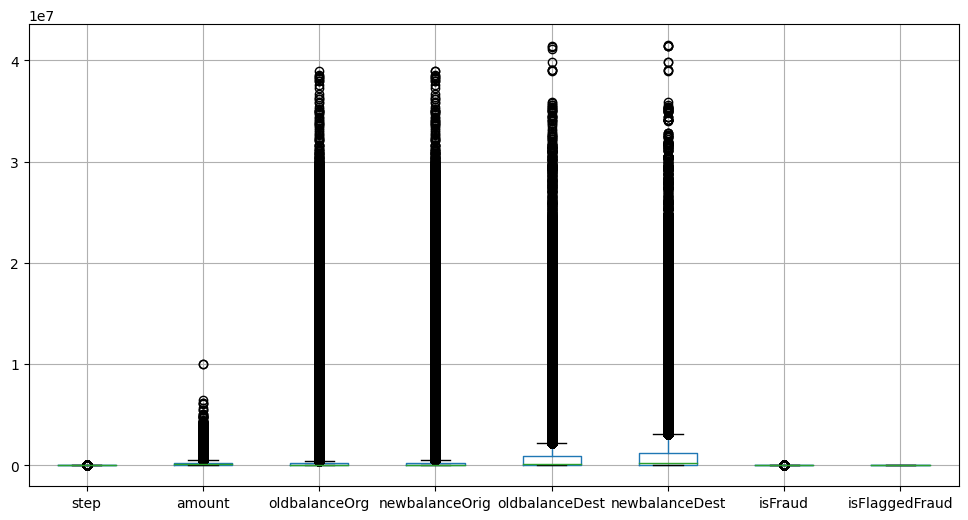

In [12]:
df.boxplot(figsize=(12,6))

In [13]:
numeric_columns = df.select_dtypes(include=['int64','float64'])

Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)
IQR = Q3 - Q1

def detect_outliers(column):
    lower_bound = Q1[column] - 1.5 * IQR[column]
    upper_bound = Q3[column] + 1.5 * IQR[column]
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    if outliers.empty:
        return None, 0.0
    else:
        percentage = (len(outliers) / len(df)) * 100
        return column, percentage

columns_with_outliers = [detect_outliers(column) for column in numeric_columns.columns]
columns_with_outliers = [(column, percentage) for column, percentage in columns_with_outliers if column is not None]

for column, percentage in columns_with_outliers:
    print(f"Column: {column}, Percentage of outliers: {percentage:.2f}%")

Column: step, Percentage of outliers: 1.25%
Column: amount, Percentage of outliers: 5.29%
Column: oldbalanceOrg, Percentage of outliers: 17.63%
Column: newbalanceOrig, Percentage of outliers: 16.50%
Column: oldbalanceDest, Percentage of outliers: 12.47%
Column: newbalanceDest, Percentage of outliers: 10.97%
Column: isFraud, Percentage of outliers: 0.06%


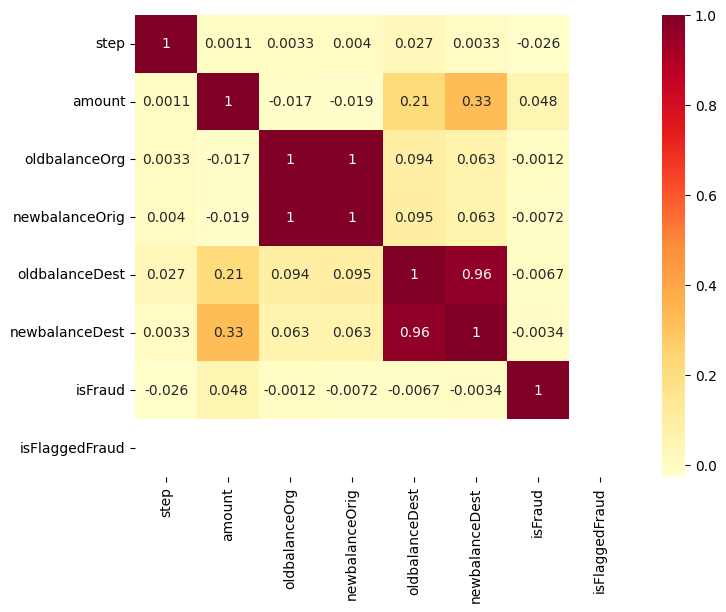

In [14]:
numeric_columns = df.select_dtypes(include=['int64', 'float64'])

correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='YlOrRd')
plt.show()

In [15]:
df.drop(columns=['oldbalanceDest', 'oldbalanceOrg'], inplace=True)

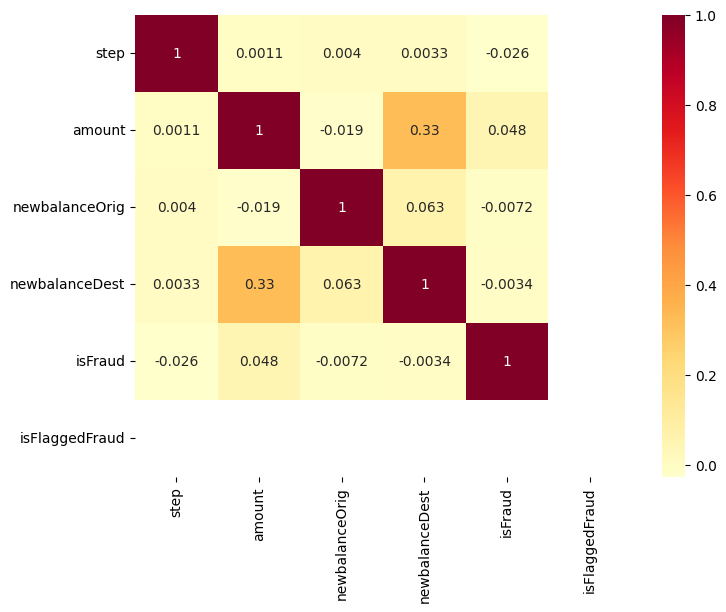

In [16]:
numeric_columns = df.select_dtypes(include=['int64', 'float64'])

correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='YlOrRd')
plt.show()

Text(0.5, 1.0, 'Distribution of Transaction Types')

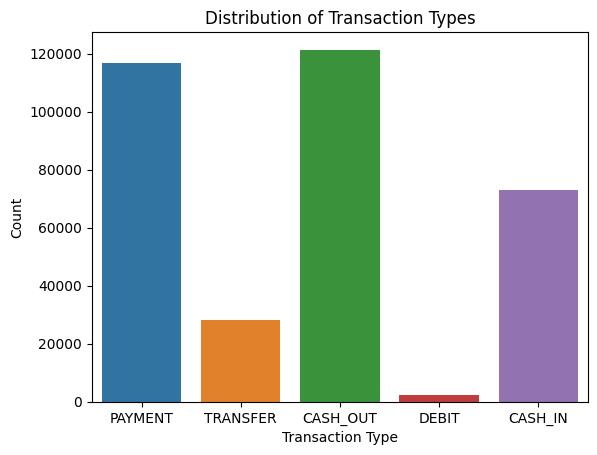

In [17]:
sns.countplot(data=df, x='type')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.title('Distribution of Transaction Types')

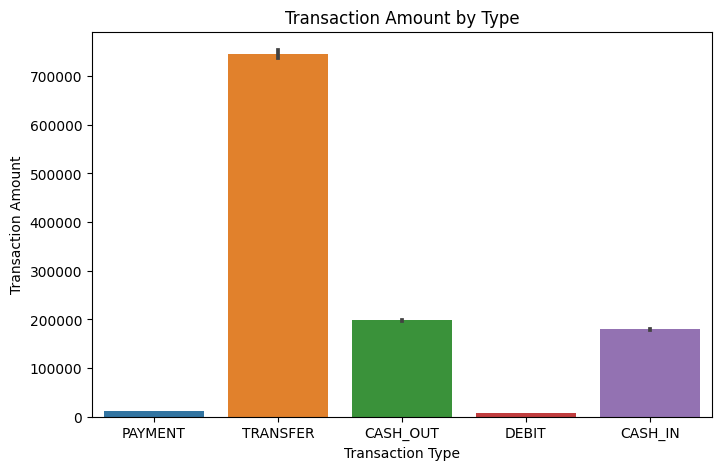

In [18]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='type', y='amount')
plt.xticks(rotation=0)
plt.xlabel('Transaction Type')
plt.ylabel('Transaction Amount')
plt.title('Transaction Amount by Type')
plt.show()

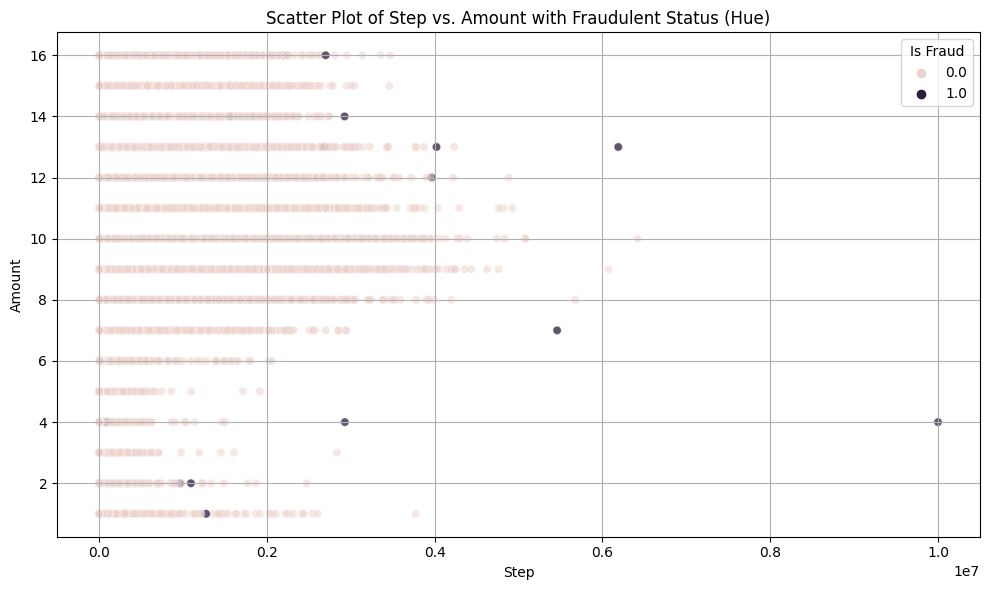

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='amount', y='step', hue='isFraud', alpha=0.5)
plt.xlabel('Step')
plt.ylabel('Amount')
plt.title('Scatter Plot of Step vs. Amount with Fraudulent Status (Hue)')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Is Fraud')
plt.show()

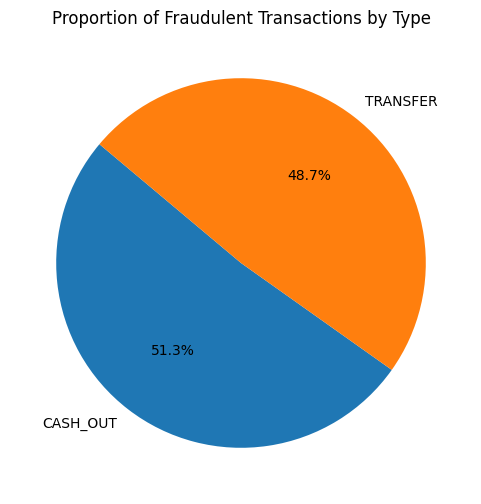

In [20]:
fraud_proportion = df[df['isFraud'] == 1]['type'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(fraud_proportion, labels=fraud_proportion.index, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Fraudulent Transactions by Type')
plt.show()

In [21]:
df_new.drop(['oldbalanceOrg','oldbalanceDest','isFlaggedFraud'],axis=1,inplace=True)

<Axes: >

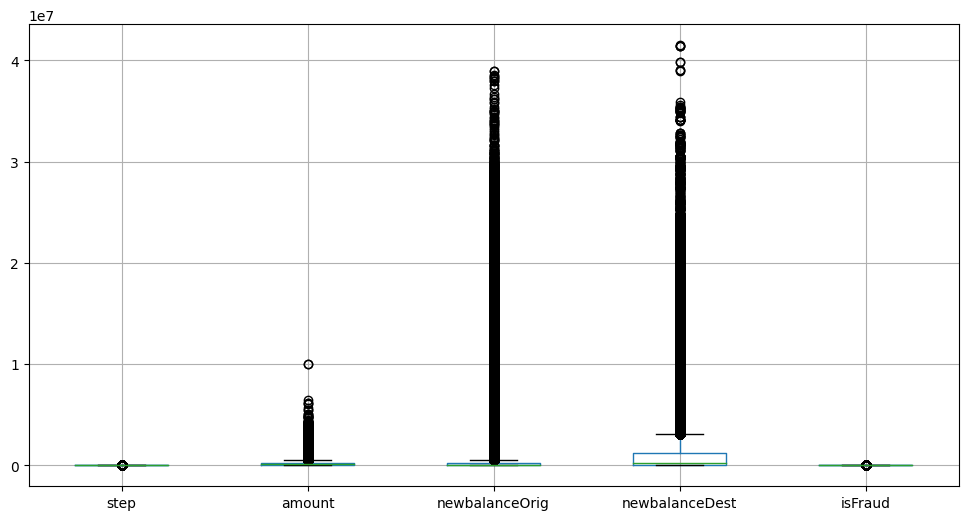

In [22]:
df_new.boxplot(figsize=(12,6))

In [23]:
numeric_columns = df_new.select_dtypes(include=['int64','float64'])

Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)
IQR = Q3 - Q1

numeric_columns = df_new.select_dtypes(include=['int64','float64'])

# Calculate quantiles for numeric columns
Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)
IQR = Q3 - Q1

# The rest of your code to detect outliers should remain the same
def detect_outliers(column):
    lower_bound = Q1[column] - 1.5 * IQR[column]
    upper_bound = Q3[column] + 1.5 * IQR[column]
    outliers = df_new[(df_new[column] < lower_bound) | (df_new[column] > upper_bound)]
    if outliers.empty:
        return None, 0.0
    else:
        percentage = (len(outliers) / len(df_new)) * 100
        return column, percentage

columns_with_outliers = [detect_outliers(column) for column in numeric_columns.columns]
columns_with_outliers = [(column, percentage) for column, percentage in columns_with_outliers if column is not None]

for column, percentage in columns_with_outliers:
    print(f"Column: {column}, Percentage of outliers: {percentage:.2f}%")

Column: step, Percentage of outliers: 1.25%
Column: amount, Percentage of outliers: 5.29%
Column: newbalanceOrig, Percentage of outliers: 16.50%
Column: newbalanceDest, Percentage of outliers: 10.97%
Column: isFraud, Percentage of outliers: 0.06%


In [24]:
def remove_outlier(col):
    sorted(col)
    Q1,Q3=col.quantile([0.25,0.75])
    IQR=Q3-Q1
    lower_range=Q1-1.5*IQR
    upper_range=Q3+1.5*IQR
    return lower_range,upper_range

In [25]:
low_leadtime,high_leadtime=remove_outlier(df_new['newbalanceOrig'])
df_new['newbalanceOrig']=np.where(df_new['newbalanceOrig']>high_leadtime,high_leadtime,df_new['newbalanceOrig'])
df_new['newbalanceOrig']=np.where(df_new['newbalanceOrig']<low_leadtime,low_leadtime,df_new['newbalanceOrig'])

In [26]:
low_leadtime,high_leadtime=remove_outlier(df_new['newbalanceDest'])
df_new['newbalanceDest']=np.where(df_new['newbalanceDest']>high_leadtime,high_leadtime,df_new['newbalanceDest'])
df_new['newbalanceDest']=np.where(df_new['newbalanceDest']<low_leadtime,low_leadtime,df_new['newbalanceDest'])

In [27]:
df_new = pd.get_dummies(df_new, columns=['type'], prefix=['type'])
df_new.shape

(341829, 12)

In [28]:
df_new.head()

,step,amount,nameOrig,newbalanceOrig,nameDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,160296.36,M1979787155,0.0,0.0,0,0,0,1,0
1,1,1864.28,C1666544295,19384.72,M2044282225,0.0,0.0,0,0,0,1,0
2,1,181.00,C1305486145,0.00,C553264065,0.0,1.0,0,0,0,0,1
3,1,181.00,C840083671,0.00,C38997010,0.0,1.0,0,1,0,0,0
4,1,11668.14,C2048537720,29885.86,M1230701703,0.0,0.0,0,0,0,1,0


In [29]:
le=LabelEncoder()
df_new['nameOrig']=le.fit_transform(df_new['nameOrig'])
df_new['nameDest']=le.fit_transform(df_new['nameDest'])

In [30]:
df_new.head(5)

,step,amount,nameOrig,newbalanceOrig,nameDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,41067,160296.36,94599,0.0,0.0,0,0,0,1,0
1,1,1864.28,117557,19384.72,98370,0.0,0.0,0,0,0,1,0
2,1,181.00,53942,0.00,27182,0.0,1.0,0,0,0,0,1
3,1,181.00,313433,0.00,24153,0.0,1.0,0,1,0,0,0
4,1,11668.14,184893,29885.86,49074,0.0,0.0,0,0,0,1,0


In [31]:
df_new['isFraud'].value_counts()

0.0    341635
1.0       193
Name: isFraud, dtype: int64

In [32]:
x=df_new.drop(['isFraud'],axis=1)
y=df_new['isFraud']

In [36]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
x, y = smote.fit_resample(x.dropna(), y.dropna())

In [37]:
y.value_counts()

0.0    341635
1.0    341635
Name: isFraud, dtype: int64

In [38]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,random_state=142)

In [39]:
print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(512452, 11)
(170818, 11)
(512452,)
(170818,)


In [40]:
sc=StandardScaler()
xtrain_sc = sc.fit_transform(xtrain)
xtest_sc=sc.transform(xtest)

In [41]:
def acc_report(actual,predicted):
    acc_score=accuracy_score(actual,predicted)
    class_rep=classification_report(actual,predicted)
    print('the accuracy of tha model is ',acc_score)
    print(class_rep)

In [42]:
lgr = LogisticRegression(max_iter=500)
lgr.fit(xtrain_sc, ytrain)

LogisticRegression(max_iter=500)

In [43]:
ypred_train_lgr=lgr.predict(xtrain_sc)
ypred_test_lgr=lgr.predict(xtest_sc)

acc_report(ytrain,ypred_train_lgr)
acc_report(ytest,ypred_test_lgr)

the accuracy of tha model is  0.8939334805991586
              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89    255907
         1.0       0.88      0.91      0.90    256545

    accuracy                           0.89    512452
   macro avg       0.89      0.89      0.89    512452
weighted avg       0.89      0.89      0.89    512452

the accuracy of tha model is  0.8944783336650705
              precision    recall  f1-score   support

         0.0       0.91      0.88      0.89     85728
         1.0       0.88      0.91      0.90     85090

    accuracy                           0.89    170818
   macro avg       0.89      0.89      0.89    170818
weighted avg       0.89      0.89      0.89    170818



In [44]:
feature_coefficients = lgr.coef_[0]

feature_importance_df = pd.DataFrame({
    'Feature': xtrain.columns,
    'Coefficient': feature_coefficients
})

feature_importance_df['Absolute_Coefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values(by='Absolute_Coefficient', ascending=False)

print(feature_importance_df)


           Feature  Coefficient  Absolute_Coefficient
9     type_PAYMENT    -8.134229              8.134229
6     type_CASH_IN    -4.939956              4.939956
7    type_CASH_OUT    -4.113463              4.113463
10   type_TRANSFER    -3.340320              3.340320
3   newbalanceOrig    -2.364174              2.364174
1           amount     1.788433              1.788433
0             step    -1.272805              1.272805
8       type_DEBIT    -1.180701              1.180701
5   newbalanceDest    -0.896983              0.896983
4         nameDest     0.891927              0.891927
2         nameOrig    -0.074099              0.074099
